In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from tqdm import tqdm
import multiprocessing as mp
import bilby
import numpy as np
from pycbc.waveform import get_td_waveform, taper_timeseries
from gwmat import point_lens
import matplotlib.pyplot as plt
import gwmat
import os
import sys
from pycbc.detector.ground import Detector
import pycbc
import bilby

import corner
from modules.gw_utils import scale_signal
import torch
from torch.utils.data import Dataset, DataLoader

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

In [2]:
num_samples = 4000
f_lower = 5.0       

priors = bilby.core.prior.PriorDict()

priors["mass1"] = bilby.core.prior.Constraint(name="mass1", minimum=10, maximum=100)
priors["mass2"] = bilby.core.prior.Constraint(name="mass2", minimum=10, maximum=100)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.2, maximum=1)
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=25, maximum=100)
priors['spin1z'] = bilby.core.prior.Uniform(name='spin1z', minimum=0.0, maximum=0.9)
priors['spin2z'] = bilby.core.prior.Uniform(name='spin2z', minimum=0.0, maximum=0.9)
# priors['eccentricity'] = bilby.core.prior.Uniform(name='eccentricity', minimum=0.1, maximum=0.6)
# priors['coa_phase'] = bilby.core.prior.Uniform(name='coa_phase', minimum=0.0, maximum=2 * np.pi)
priors['distance'] = bilby.core.prior.Uniform(name='distance', minimum=100, maximum=1000)
priors['dec'] = bilby.core.prior.Cosine(minimum=-np.pi/2, maximum=np.pi/2)
priors['ra'] = bilby.core.prior.Uniform(minimum=0., maximum=2*np.pi, boundary="periodic")
priors['polarization'] = bilby.core.prior.Uniform(minimum=0., maximum=np.pi, boundary="periodic")

priors['Log_Mlz'] = bilby.core.prior.Uniform(minimum = 3, maximum = 5)
priors['yl'] = bilby.core.prior.PowerLaw(alpha = 1, minimum = 0.01, maximum = 1.0)

parameters_list = priors.sample(num_samples)

samples = [
    {key: parameters_list[key][i] for key in parameters_list}
    for i in range(num_samples)
]

print(f"Length of parameters_list: {len(samples)}")

01:43 bilby WARNING : Prior sampling efficiency is very low, please verify its validity.


Length of parameters_list: 4000


In [3]:
def waveform(num):
    parameters = samples[num].copy()

    mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(parameters['chirp_mass'], parameters['mass_ratio'])

    m_lens = np.power(10., parameters.pop("Log_Mlz"))
    y_lens = parameters.pop("yl")

    sp, sc = get_td_waveform(
        approximant='teobresums',
        mass1=mass1,
        mass2=mass2,
        lambda1=0,
        lambda2=0,
        spin1z=parameters['spin1z'],
        spin2z=parameters['spin2z'],
        distance=parameters['distance'],
        delta_t=1.0 / 4096 ,
        ecc=0,
        # coa_phase=parameters['coa_phase'],
        f_lower=5,
    )

    ####---------------------Generating Lensed Waveform--------------------####

    sp_freq = sp.to_frequencyseries(delta_f = sp.delta_f)
    sc_freq = sc.to_frequencyseries(delta_f = sc.delta_f)

    fs1 = sp_freq.sample_frequencies
    assert np.allclose(fs1, sc_freq.sample_frequencies), "Sample frequencies do not match!"

    Ffs_sp = np.vectorize(lambda f: gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens))(fs1)
        
    time_Delay = point_lens.time_delay(ml=m_lens, y=y_lens)

    sp_lensed = pycbc.types.FrequencySeries(np.conj(Ffs_sp) * np.asarray(sp_freq), delta_f=sp_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))
    sc_lensed = pycbc.types.FrequencySeries(np.conj(Ffs_sp) * np.asarray(sc_freq), delta_f=sc_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))

    sp_lensed = sp_lensed.to_timeseries(delta_t=sp_lensed.delta_t)
    sc_lensed = sc_lensed.to_timeseries(delta_t=sc_lensed.delta_t)


    ####---------------------Projecting on detector--------------------####

    detector = Detector('H1')

    lensed_signal = detector.project_wave(sp_lensed, sc_lensed, ra = parameters['ra'], dec = parameters['dec'], polarization = parameters['polarization'])

    lensed_signal = taper_timeseries(lensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

    lensed_noisy, lensed_snr = scale_signal(lensed_signal, num)

    lensed_noisy = lensed_noisy.crop(left=24, right=0)

    return np.array(lensed_noisy)

In [4]:
def simulator(num):
    return waveform(num), list(samples[num].values())

In [ ]:
num_simulations = num_samples

# theta_vals = []
# data_vals = []
# for ii in range(num_simulations):
#     y_val, theta_val = simulator(ii)
#     data_vals.append(y_val)
#     theta_vals.append(theta_val)

def simulate_one(ii):
    y_val, theta_val = simulator(ii)
    return theta_val, y_val

In [ ]:
num_simulations = num_samples

if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(simulate_one, range(num_simulations))


theta_vals, data_vals = zip(*results)

Scaling signal to achieve SNR of 12.72 for sample 7
Scaling signal to achieve SNR of 12.72 for sample 547


/home/qubit/miniconda3/envs/nn_1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: overflow encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


Scaling signal to achieve SNR of 15.04 for sample 551
Scaling signal to achieve SNR of 10.73 for sample 322
Scaling signal to achieve SNR of 15.18 for sample 1372
Scaling signal to achieve SNR of 14.75 for sample 1303
Scaling signal to achieve SNR of 14.65 for sample 1054
Scaling signal to achieve SNR of 14.75 for sample 1915
Scaling signal to achieve SNR of 17.74 for sample 1674
Scaling signal to achieve SNR of 17.88 for sample 1856
Scaling signal to achieve SNR of 19.80 for sample 1282
Scaling signal to achieve SNR of 13.96 for sample 1969
Scaling signal to achieve SNR of 14.85 for sample 1475
Scaling signal to achieve SNR of 14.38 for sample 1294
Scaling signal to achieve SNR of 19.40 for sample 2664
Scaling signal to achieve SNR of 11.72 for sample 2014
Scaling signal to achieve SNR of 14.38 for sample 2223
Scaling signal to achieve SNR of 10.45 for sample 2472
Scaling signal to achieve SNR of 18.25 for sample 2338
Scaling signal to achieve SNR of 19.85 for sample 3014
Scaling sign

In [7]:
# for i, d in enumerate(data_vals):
#     print(f"Index {i}: shape = {np.shape(d)}")

# from torch.nn.utils.rnn import pad_sequence

# # Convert your data to tensors if not already
# tensor_vals = [torch.tensor(d, dtype=torch.float32) for d in data_vals]

# # Pad to the same length (default padding value is 0.0)
# # This returns a tensor of shape (max_length, batch_size)
# padded = pad_sequence(tensor_vals, batch_first=True)

# data_vals = padded.numpy()

In [9]:
# convert to torch tensors
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

# create dataset
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

dataset = DataGenerator()

# create dataloaders - 80/10/10 split
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

train_data_loader = DataLoader(
    train_data, batch_size=256,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=256,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [10]:
len(train_data_loader), len(val_data_loader), len(test_data_loader)

(13, 2, 400)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
num_transforms = 24
num_blocks = 24
hidden_features = 50

context_features = data_vals[0].shape[0]
parameter_space_dim = len(samples[0].keys())

base_dist = StandardNormal([parameter_space_dim])  

transforms = []

for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
                features=parameter_space_dim, 
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                activation=torch.tanh,
                use_batch_norm=True,
                use_residual_blocks=False,
        ),
        RandomPermutation(features=parameter_space_dim)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [13]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
for i in range(200):
    flow.train()
    train_loss_total = 0.0

    train_loader = tqdm(train_data_loader, desc=f"Epoch {i+1} [Train]", leave=False)
    for idx, val in enumerate(train_loader):
        theta, data = val
        theta = theta.to(device)
        data = data.to(device)

        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        loss.backward()
        optimizer.step()
        
        train_loss_total += loss.item()
        train_loader.set_postfix(loss=loss.item())

    scheduler.step()
    train_loss_avg = train_loss_total / len(train_data_loader)

    flow.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        val_loader = tqdm(val_data_loader, desc=f"Epoch {i+1} [Val]", leave=False)
        for idx, val in enumerate(val_loader):
            theta, data = val
            theta = theta.to(device)
            data = data.to(device)

            val_loss_batch = -flow.log_prob(theta, context=data).mean()
            val_loss_total += val_loss_batch.item()
            val_loader.set_postfix(loss=val_loss_batch.item())

    val_loss_avg = val_loss_total / len(val_data_loader)

    if i == 0 or (i+1) % 10 == 0:
        print(f"[Epoch {i+1}] Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

[Epoch 1] Train Loss: 73.7375 | Val Loss: 71.1013


[Epoch 10] Train Loss: 21.4657 | Val Loss: 27.9343


[Epoch 20] Train Loss: 16.8796 | Val Loss: 18.2365


[Epoch 30] Train Loss: 16.4130 | Val Loss: 17.8506


[Epoch 40] Train Loss: 16.2076 | Val Loss: 16.9135


[Epoch 50] Train Loss: 16.1049 | Val Loss: 16.9805


[Epoch 60] Train Loss: 16.0248 | Val Loss: 16.6256


[Epoch 70] Train Loss: 15.9831 | Val Loss: 16.6412


[Epoch 80] Train Loss: 15.9480 | Val Loss: 16.8531


[Epoch 90] Train Loss: 15.9170 | Val Loss: 16.8316


[Epoch 100] Train Loss: 15.9292 | Val Loss: 16.7970


[Epoch 110] Train Loss: 15.9116 | Val Loss: 16.6874


[Epoch 120] Train Loss: 15.9027 | Val Loss: 16.7649


[Epoch 130] Train Loss: 15.8919 | Val Loss: 16.8242


[Epoch 140] Train Loss: 15.9029 | Val Loss: 16.7858


[Epoch 150] Train Loss: 15.8782 | Val Loss: 16.8552


[Epoch 160] Train Loss: 15.8968 | Val Loss: 16.8571


[Epoch 170] Train Loss: 15.8997 | Val Loss: 16.6467


[Epoch 180] Train Loss: 15.9198 | Val Loss: 16.8493


[Epoch 190] Train Loss: 15.8940 | Val Loss: 16.7483


[Epoch 200] Train Loss: 15.9066 | Val Loss: 16.8192


In [16]:
torch.save(flow.state_dict(), "flow_bbh.pth")

# flow = torch.load_state_dict("flow_bbh.pth", map_location=device)

In [15]:
theta_test, data_test = next(iter(test_data_loader))
theta_test = theta_test.to(device)
data_test = data_test.to(device)
with torch.no_grad():
        posterior_samples = flow.sample(5000, context=data_test.reshape(tuple(data_test.shape)))

theta_test = theta_test.squeeze(0)

In [16]:
theta_test

tensor([2.9969e-01, 6.2209e+01, 5.5467e-01, 6.5017e-01, 6.5335e+02, 5.1379e-01,
        5.0169e+00, 1.5481e+00, 3.5678e+00, 6.9636e-01], device='cuda:0')

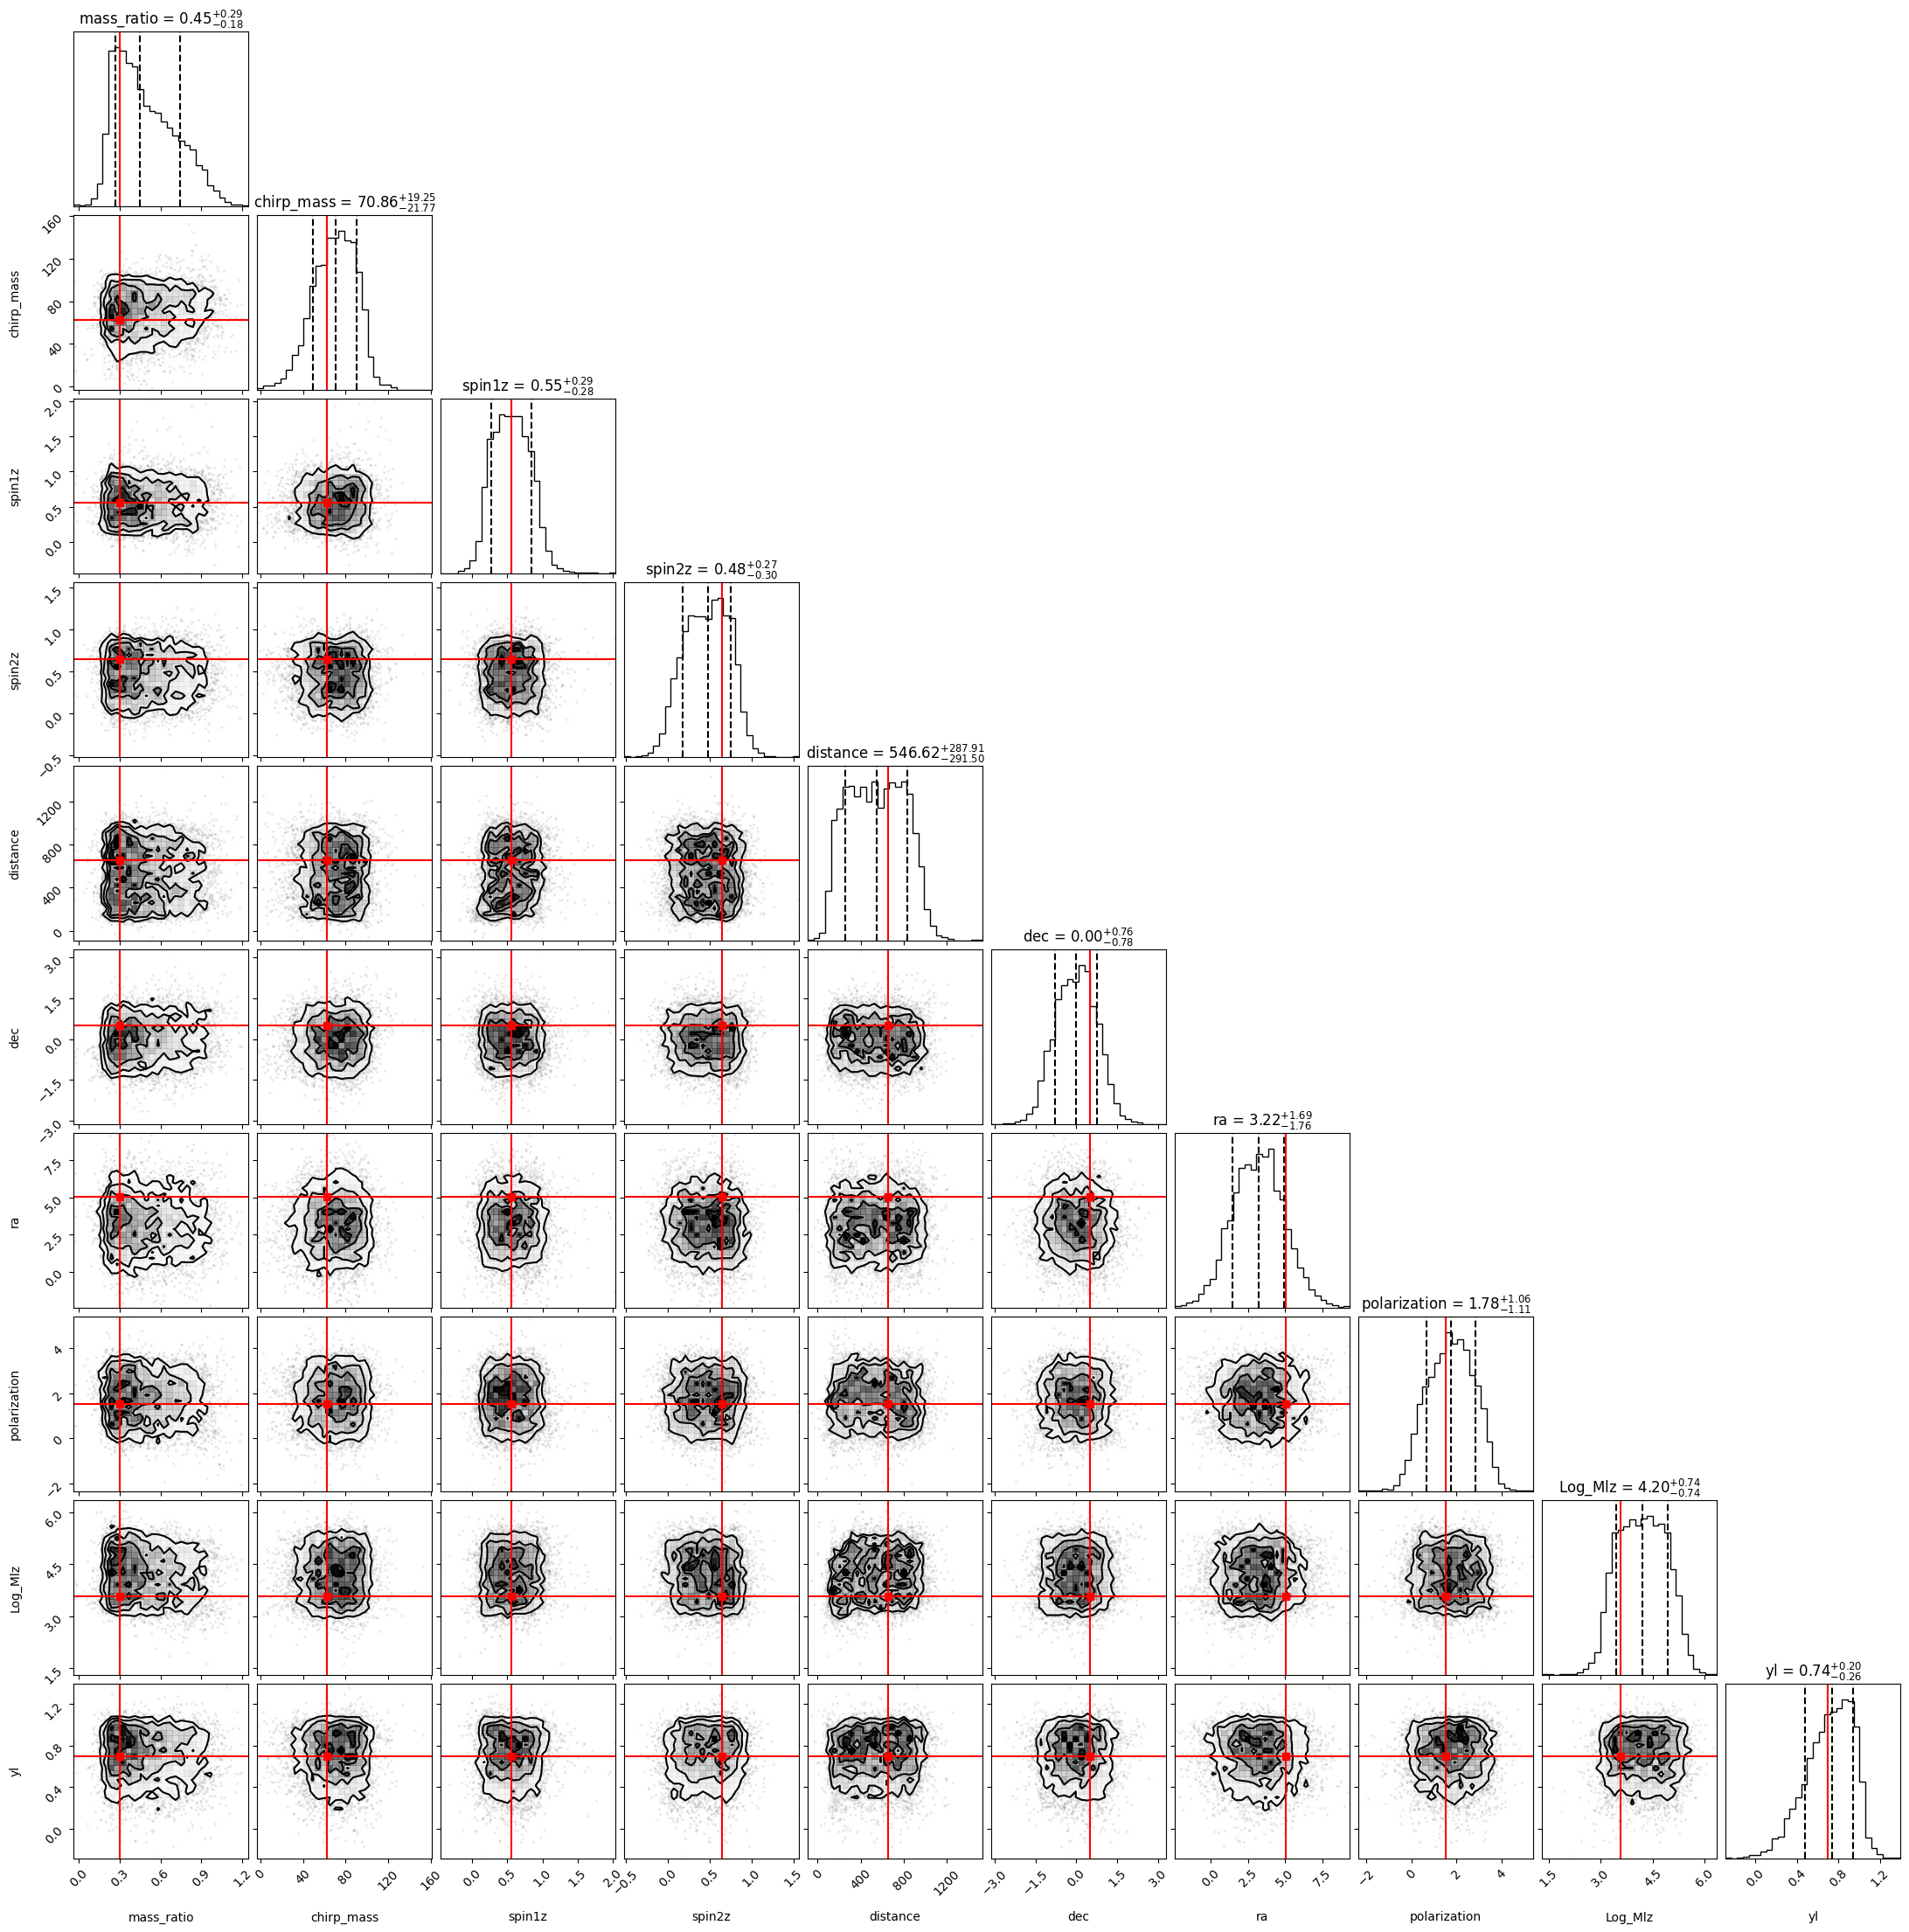

In [ ]:
data = posterior_samples.squeeze(0).cpu().numpy() 

figure = corner.corner(
    data,
    bins=30,  # Number of bins
    labels=list(samples[0].keys()),
    quantiles=[0.16, 0.5, 0.84], 
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=theta_test.cpu().numpy(),
    truth_color="red",
)

# plt.axvline(x=0, color='k', linestyle='--')
plt.show()

In [ ]:
from modules.pp_plot_code import calculate_pp_values, plot_pp_plot, compute_pp_statistics, plot_overlay_pp_plot, plot_individual_pp_plots

Computing P-P values: 100%|██████████| 400/400 [07:15<00:00,  1.09s/it]

Generating overlaid P-P plot...


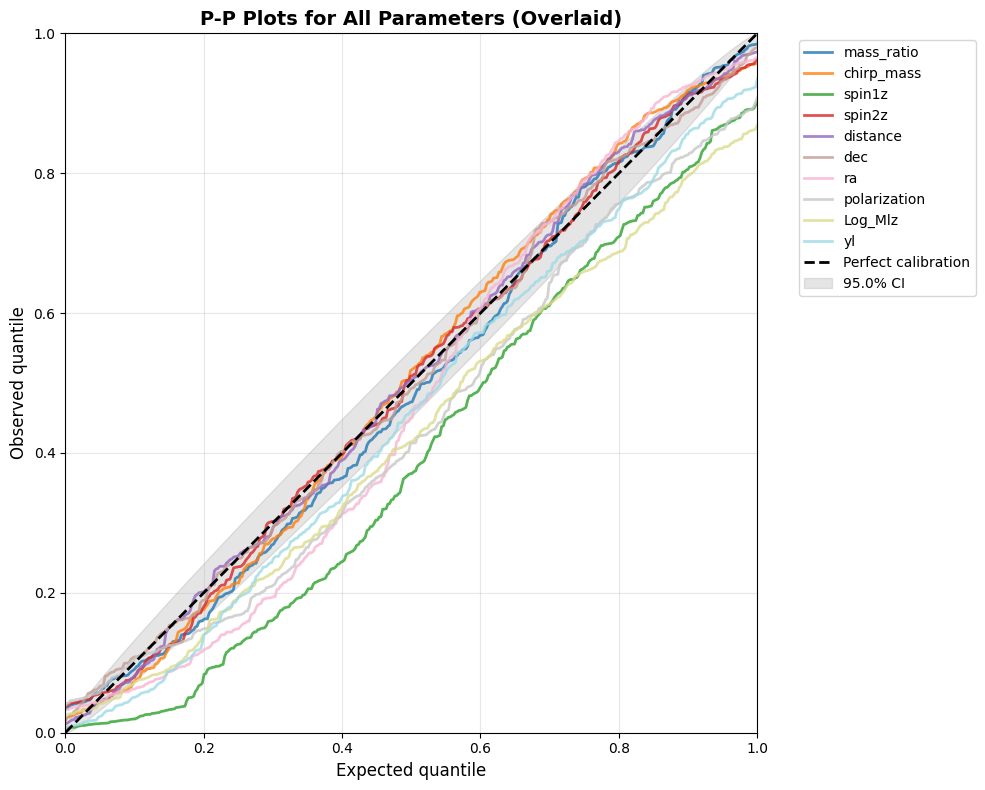

P-P Plot Statistics:

mass_ratio:
  Mean P-value: 0.4893 (should be ~0.5)
  Std P-value: 0.2975 (should be ~0.2887)
  KS test p-value: 0.3897 (>0.05 indicates good calibration)

chirp_mass:
  Mean P-value: 0.5042 (should be ~0.5)
  Std P-value: 0.3043 (should be ~0.2887)
  KS test p-value: 0.3127 (>0.05 indicates good calibration)

spin1z:
  Mean P-value: 0.3963 (should be ~0.5)
  Std P-value: 0.2921 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

spin2z:
  Mean P-value: 0.4986 (should be ~0.5)
  Std P-value: 0.2920 (should be ~0.2887)
  KS test p-value: 0.5085 (>0.05 indicates good calibration)

distance:
  Mean P-value: 0.5032 (should be ~0.5)
  Std P-value: 0.2966 (should be ~0.2887)
  KS test p-value: 0.5635 (>0.05 indicates good calibration)

dec:
  Mean P-value: 0.4998 (should be ~0.5)
  Std P-value: 0.2878 (should be ~0.2887)
  KS test p-value: 0.5022 (>0.05 indicates good calibration)

ra:
  Mean P-value: 0.4735 (should be ~0.5)
  Std P-value: 

In [19]:

if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # flow.load_state_dict(torch.load('trained_flow_model.pth'))
    
    pp_values, parameter_names = calculate_pp_values(
        flow, test_data_loader, device, num_posterior_samples=5000
    )
    

    # print("Generating P-P plots in subplot grid...")
    # fig = plot_pp_plot(pp_values, parameter_names, confidence_level=0.95)
    
    print("Generating overlaid P-P plot...")
    plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95)

    compute_pp_statistics(pp_values, parameter_names)
    
    np.save('pp_values.npy', pp_values)
    np.save('parameter_names.npy', parameter_names)
    
    print("\nP-P analysis completed!")